### Questão (a)
Aplique uma rede MLP com uma camada intermediária e analise (1) a acurácia e (2) a matriz de confusão para
os dados de teste obtidas pela melhor versão desta rede. Descreva a metodologia e a arquitetura empregada,
bem como todas as escolhas feitas.

In [113]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical

from medmnist import BloodMNIST

In [114]:
# Importing data

INPUT_N = 28

train_dataset = BloodMNIST(split="train", download=True, size=INPUT_N)

X_train_full = np.zeros([len(train_dataset), INPUT_N, INPUT_N, 3]) 

y_train_full = np.zeros([len(train_dataset), 1])

for i in range(len(train_dataset)):
    x, y_train_full[i] = train_dataset[i]
    X_train_full[i] = np.array(x)/255.0
    
i_val = int(len(train_dataset)*0.7)

X_train = X_train_full[:i_val]
y_train = y_train_full[:i_val]

X_val = X_train_full[i_val:]
y_val = y_train_full[i_val:]

print('Number of samples in train dataset: '+str(len(train_dataset)))

print('Shape of data in train dataset: '+str(X_train.shape)+" "+str(y_train.shape))

print('Shape of data in validation dataset: '+str(X_val.shape)+" "+str(y_val.shape))

test_dataset = BloodMNIST(split="test", download=True, size=INPUT_N)

X_test = np.zeros([len(test_dataset), INPUT_N, INPUT_N, 3])

y_test = np.zeros([len(test_dataset), 1])

for i in range(len(test_dataset)):
    x, y_test[i] = test_dataset[i]
    X_test[i] = np.array(x)/255.0

print('Number of samples in test dataset: '+str(len(test_dataset)))

print('Shape of data in test dataset: '+str(X_test.shape)+" "+str(y_test.shape))




Using downloaded and verified file: /home/toffanetto/.medmnist/bloodmnist.npz
Number of samples in train dataset: 11959
Shape of data in train dataset: (8371, 28, 28, 3) (8371, 1)
Shape of data in validation dataset: (3588, 28, 28, 3) (3588, 1)
Using downloaded and verified file: /home/toffanetto/.medmnist/bloodmnist.npz
Number of samples in test dataset: 3421
Shape of data in test dataset: (3421, 28, 28, 3) (3421, 1)


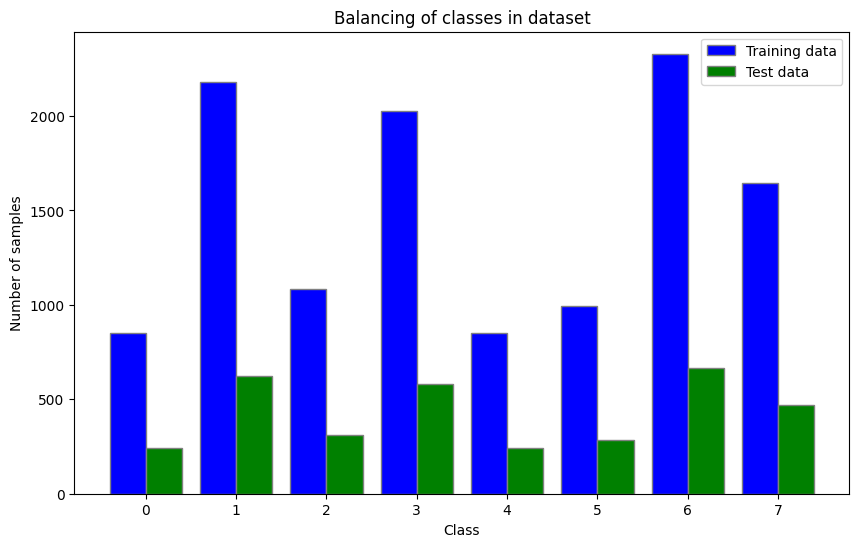

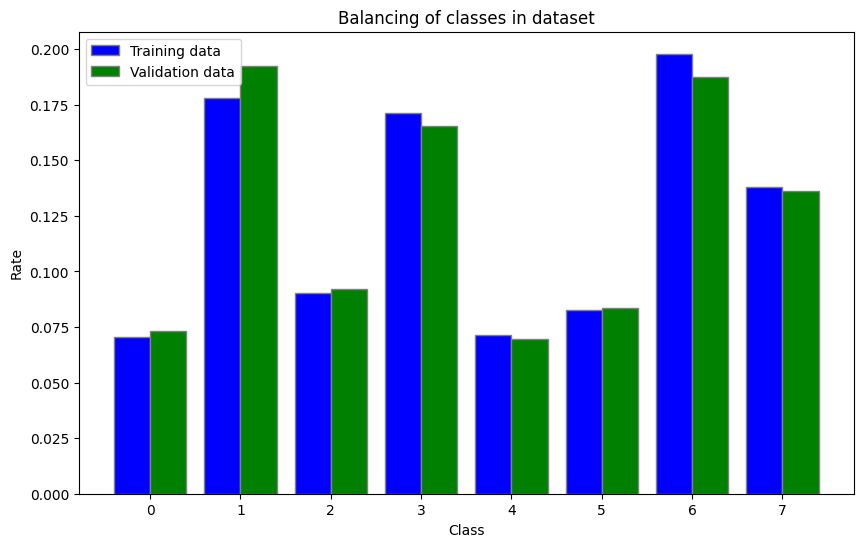

In [115]:
# Dataset balancing

train_one_hot = to_categorical(y_train_full)
test_one_hot =  to_categorical(y_test)
                                 
train_balancing = np.sum(train_one_hot, axis=0)
test_balancing = np.sum(test_one_hot, axis=0)

barWidth = 0.4

plt.figure(figsize=(10,6))
 
# Set position of bar on X axis 
br1 = np.arange(len(train_balancing)) 
br2 = [x + barWidth for x in br1] 
 
# Make the plot
plt.bar(br1, train_balancing, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Training data') 
plt.bar(br2, test_balancing, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Test data') 
 
# Adding Xticks 
plt.xlabel('Class') 
plt.ylabel('Number of samples') 
plt.xticks([r + barWidth/2 for r in range(len(train_balancing))], 
        ['0', '1', '2', '3', '4', '5', '6', '7'])
plt.title('Balancing of classes in dataset')
 
plt.legend(loc='upper right')

plt.savefig("../plot/Balancing_of_classes.pdf", format="pdf", bbox_inches="tight")

# Using holdout

train_one_hot = to_categorical(y_train)
val_one_hot =  to_categorical(y_val)
                                 
train_balancing = np.sum(train_one_hot, axis=0)
val_balancing = np.sum(val_one_hot, axis=0)

train_balancing = train_balancing/np.sum(train_balancing)
val_balancing = val_balancing/np.sum(val_balancing)

barWidth = 0.4

plt.figure(figsize=(10,6))
 
# Set position of bar on X axis 
br1 = np.arange(len(train_balancing)) 
br2 = [x + barWidth for x in br1] 
 
# Make the plot
plt.bar(br1, train_balancing, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Training data') 
plt.bar(br2, val_balancing, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Validation data') 
 
# Adding Xticks 
plt.xlabel('Class') 
plt.ylabel('Rate') 
plt.xticks([r + barWidth/2 for r in range(len(train_balancing))], 
        ['0', '1', '2', '3', '4', '5', '6', '7'])
plt.title('Balancing of classes in dataset')
 
plt.legend(loc='upper left')

plt.savefig("../plot/Balancing_of_classes_holdout.pdf", format="pdf", bbox_inches="tight")

---
### Busca pela melhor rede

Busca em grid variando alguns valores como:

- Quantidade de neuronios (512, 1024, 2048, 4096, 8192)
- Função de ativação (sigmoid, ReLU)
- Dropout (0, 0,25, 0,5)
- Otimizador (adam, sgd)

Treinar muitas épocas com a callback de salvar a melhor época

---

In [116]:
def build_and_test_mlp(n_neurons=64, activation_fnc="relu", dropout=0.0, optimizer="sgd", epochs=300):
    
    tf.keras.backend.clear_session() # Free memory and clear old models in session
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=[INPUT_N,INPUT_N,3]))
    model.add(tf.keras.layers.Dense(n_neurons,activation=activation_fnc))
    model.add(tf.keras.layers.Dropout(rate=dropout))
    model.add(tf.keras.layers.Dense(8, activation="softmax"))
    
    model.summary()
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint("../model/mlp/mlp_"+str(n_neurons)+"_"+(activation_fnc)+"_"+str(dropout)+"_"+(optimizer)+".weights.h5",
                                                    save_best_only=True, save_weights_only=True)
    
    history = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpoint_cb])
    
    loss, accuracy = model.evaluate(X_test,y_test)
    
    model_specs = dict(n_neurons=n_neurons,
                       activation_fnc=activation_fnc,
                       dropout=dropout,
                       optimizer=optimizer,
                       loss=loss,
                       accuracy=accuracy)
    
    return model_specs, history

In [ ]:
# Test custom model

model_specs, history = build_and_test_mlp(epochs=100)

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.ylim([0,1])

print(model_specs)


In [ ]:
epochs = 500

n_neurons_search = [256, 512, 1024, 2048, 4096]

activation_fnc_search = ["relu", "sigmoid"]

dropout_search = [0.0, 0.25, 0.5]

optimizer_search = ["adam", "sgd"]


In [ ]:
############################################
# Number of neurons search

n_neurons_models = []
n_neurons_historys = []

for n_neurons in n_neurons_search:
    print("|++| Training for "+str(n_neurons)+" neurons |++|\n")
    model_specs, history = build_and_test_mlp(n_neurons=n_neurons,epochs=epochs)
    n_neurons_models.append(model_specs)
    n_neurons_historys.append(history)
    
best_model_neurons = dict(n_neurons=0,
                          activation_fnc="",        
                          dropout=0,
                          optimizer="",
                          loss=0,
                          accuracy=0)

for model in n_neurons_models:
    if model["accuracy"] > best_model_neurons["accuracy"]:
        best_model_neurons = model
    
best_n_neurons = best_model_neurons["n_neurons"]

print(n_neurons_models)


In [ ]:
############################################
# Activation function search

activation_fnc_models = []
activation_fnc_historys = []

for activation_fnc in activation_fnc_search:
    model_specs, history = build_and_test_mlp(n_neurons=best_n_neurons,activation_fnc=activation_fnc,
                                              epochs=epochs)
    activation_fnc_models.append(model_specs)
    activation_fnc_historys.append(history)
    
best_model_activation_fnc = dict(n_neurons=0,
                                 activation_fnc="",    
                                 dropout=0,             
                                 optimizer="",          
                                 loss=0,                 
                                 accuracy=0)

for model in activation_fnc_models:
    if model["accuracy"] > best_model_neurons["accuracy"]:
        best_model_neurons = model

best_activation_fnc = best_model_neurons["activation_fnc"]

print(activation_fnc_models)


In [ ]:
############################################
# Dropout search

dropout_models = []
dropout_historys = []

for dropout in dropout_search:
    model_specs, history = build_and_test_mlp(n_neurons=best_n_neurons,activation_fnc=best_activation_fnc, 
                                              dropout=dropout, epochs=epochs)
    dropout_models.append(model_specs)
    dropout_historys.append(history)
    
best_model_dropout = dict(n_neurons=0,           
                          activation_fnc="",                
                          dropout=0,                       
                          optimizer="",            
                          loss=0,    
                          accuracy=0)

for model in best_model_dropout:
    if model["accuracy"] > best_model_neurons["accuracy"]:
        best_model_neurons = model

best_dropout = best_model_neurons["dropout"]

print(dropout_models)

In [ ]:

############################################
# Optimizer search

optimizer_models = []
optimizer_historys = []

for optimizer in optimizer_search:
    model_specs, history = build_and_test_mlp(n_neurons=best_n_neurons,activation_fnc=best_activation_fnc, 
                                              dropout=best_dropout, optimizer=optimizer, epochs=epochs)
    optimizer_models.append(model_specs)
    optimizer_historys.append(history)
    
best_model_optimizer = dict(n_neurons=0,           
                            activation_fnc="",                
                            dropout=0,                       
                            optimizer="",            
                            loss=0,    
                            accuracy=0)

for model in best_model_optimizer:
    if model["accuracy"] > best_model_neurons["accuracy"]:
        best_model_neurons = model

best_optimizer = best_model_neurons["optimizer"]

print(optimizer_models)

In [ ]:
print(best_model_neurons["accuracy"])
print(best_model_activation_fnc["accuracy"])
print(best_model_dropout["accuracy"])
print(best_model_optimizer["accuracy"])

best_model = dict(n_neurons=best_n_neurons,
                  activation_fnc=best_activation_fnc,
                  dropout=best_dropout,
                  optimizer=best_optimizer)

print("\nBest model founded: "+str(best_model))
    


---
Uma vez definido o melhor modelo, obter dele:
- Acurácia (balanceada) 
- Matriz de confusão
- Comparar amostras que erraram 
  - O quanto errou, com qual classe confundiu
  - Comparação visual

---

In [ ]:
model_specs, history = build_and_test_mlp(n_neurons=best_model["n_neurons"],activation_fnc=best_model["activation_fnc"],
                                          dropout=best_model["dropout"],optimizer=best_model["optimizer"], epochs=epochs)